# Lab 3 — recommender systems

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.style.use("ggplot")

What does the data look like?

In [2]:
!hdfs dfs -cat /ix/ml-20m/ratings.txt | tail -n 2

{"movieId": 70286, "userId": 138493, "timestamp": 1258126944, "rating": 5.0}
{"movieId": 71619, "userId": 138493, "timestamp": 1255811136, "rating": 2.5}


## 3.4 Basic statistics

In [3]:
ratings = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)

In [4]:
sum2 = lambda a, b: a + b
num_rating_per_user = ratings.map(lambda obj : (obj['userId'], 1)).reduceByKey(sum2).sortByKey().values().collect()
num_rating_per_movie = ratings.map(lambda obj : (obj['movieId'], 1)).reduceByKey(sum2).sortByKey().values().collect()

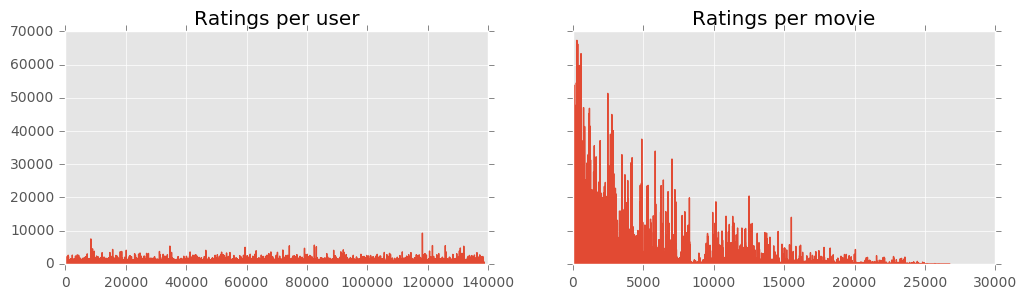

In [5]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 3), sharey=True)
ax1.plot(num_rating_per_user)
ax1.set_title("Ratings per user")
ax2.plot(num_rating_per_movie)
ax2.set_title("Ratings per movie")

We can see that the ratings per user is generally balanced, which is not the case for the ratings per movie. Some movies have much more ratings than others.

## 3.5 Partitioning the dataset

In [6]:
#Couldnt read file so I did it manually
my_ratings = sc.parallelize([
    {"movieId": 1, "rating": 5, "timestamp": 1491989698, "userId": 138494},
    {"movieId": 780, "rating": 3, "timestamp": 1491989704, "userId": 138494},
    {"movieId": 590, "rating": 4, "timestamp": 1491989707, "userId": 138494},
    {"movieId": 1210, "rating": 5, "timestamp": 1491989709, "userId": 138494},
    {"movieId": 648, "rating": 3, "timestamp": 1491989712, "userId": 138494},
    {"movieId": 344, "rating": 3, "timestamp": 1491989722, "userId": 138494},
    {"movieId": 165, "rating": 3, "timestamp": 1491989727, "userId": 138494},
    {"movieId": 153, "rating": 2, "timestamp": 1491989731, "userId": 138494},
    {"movieId": 597, "rating": 1, "timestamp": 1491989734, "userId": 138494},
    {"movieId": 1580, "rating": 3, "timestamp": 1491989743, "userId": 138494},
    {"movieId": 231, "rating": 2, "timestamp": 1491989750, "userId": 138494},
])

In [7]:
#Add my ratings
complete_ratings = ratings.union(my_ratings)

In [8]:
#Split the data set using the last digit of time stamp (80%-20%)
def less_than_eight(x):
    return x['timestamp'] %10 < 8

def more_than_eight(x):
    return not less_than_eight(x)

training_data, validation_data = (complete_ratings.filter(f).cache() for f in (less_than_eight, more_than_eight))

## 3.6 Baseline model

In [9]:
def sumTuples(tup1, tup2):
    return (tup1[0] + tup2[0] , tup1[1] + tup2[1])
def RDDmean(rdd):
    seqOp = lambda acc, rating: (acc[0] + rating, acc[1] + 1)
    total, count = rdd.aggregate((0, 0), seqOp, sumTuples)
    return total / count

In [10]:
global_average = RDDmean(training_data.map(lambda j: j['rating']))
global_average

3.5255161464366283

In [11]:
# (uId, (rating-mu, 1)) then (uid, (sum of ratings of score, count)) then (uid, alpha_u)
pairCreator = lambda j: (j['userId'], (j['rating'] - global_average, 1))
alphas = training_data.map(pairCreator).reduceByKey(sumTuples).mapValues(lambda tup: tup[0] / tup[1]).cache()

In [12]:
pairCreator = lambda j: (j['userId'],  (j['movieId'], j['rating']))
# flatten used to map (userId, ((movieId, rating), alpha)) to (movieId, (rating, alpha))
flatten = lambda t: (t[1][0][0], (t[1][0][1], t[1][1]))
seqOp = lambda acc, tr: (acc[0] + tr[0] - tr[1] - global_average, acc[1] + 1)
with_alpha = training_data.map(pairCreator).join(alphas).map(flatten)
betas = with_alpha.aggregateByKey((0,0), seqOp, sumTuples, numPartitions=training_data.getNumPartitions()).mapValues(lambda t: t[0] / t[1]).cache()

In [13]:
default_alpha = RDDmean(alphas.values())
default_beta = RDDmean(betas.values())
(default_alpha, default_beta)

(0.10166146018546321, -0.20450786155878353)

In [14]:
placeholder = validation_data.map(lambda j: (j['userId'], (j['movieId'], 1)))

def fixEmptyUser(t):
    """ Replaces missing alphas with default value and converts to format:
    (movieId, (userId, alpha))
    """
    alpha = t[1][1] if not t[1][1] == None else default_alpha
    return (t[1][0][0], (t[0], alpha))

withAlphas = placeholder.leftOuterJoin(alphas, numPartitions=training_data.getNumPartitions()).map(fixEmptyUser)

def fixEmptyMovies(t):
    """ Replaces missing betas with default value and converts to format:
    ((userId, movieId), (alpha, beta))
    """
    beta = default_beta if t[1][1] is None else t[1][1]
    return ((t[1][0][0], t[0]) , (t[1][0][1], beta))

userMovieToBiases = withAlphas.leftOuterJoin(betas, numPartitions=training_data.getNumPartitions()).map(fixEmptyMovies)

compute_single_rank = lambda biases: biases[0] + biases[1] + global_average

scores = userMovieToBiases.map(lambda t: (t[0][0], t[0][1], compute_single_rank(t[1])))

## 3.5 Evaluation

In [15]:
val = validation_data.map(lambda j: ((j['userId'], j['movieId']), j['rating']))

In [18]:
import math
def error(rdd):
    tmp = rdd.map(lambda t: ((t[0], t[1]), t[2])) # ((userId, movieId), rating)
    mixed = val.join(tmp)
    byUser = mixed.map(lambda t: (t[0][0], (t[1][1], t[1][0]))) # (userId, (computedScore, scoreInValidation))
    numUsers = byUser.keys().distinct().count()
    square = lambda x: x*x
    seqOp = lambda acc, t: (acc[0] + square(t[0] - t[1]) , acc[1] + 1)
    return byUser.aggregateByKey((0, 0), seqOp, sumTuples).map(lambda t: math.sqrt(t[1][0] / t[1][1])).sum() / numUsers

In [19]:
error(scores)

0.8669177244805791

# -

In [40]:
#Predict rating of userId 'user' for movieId 'movie' from given training data 'data'
#TODO: add avg values when no rating per user/movie in a and b!!!
#Note: some users / movies do not have any ratings. Use sensible default values for au and bm
def global_rating(data):
    N = data.map(lambda obj : obj['rating'])
    u = N.sum() / N.count()
    return u

def alpha_u(data, userId, u):
    Nu = data.filter(lambda x : x['userId'] == userId).map(lambda obj : obj['rating'])
    a_u = Nu.map(lambda x : x - u).sum() / Nu.count()
    return a_u

def beta_m(data, movieId, a_u_list, u):
    Nm = data.filter(lambda x : x['movieId'] == movieId).map(lambda obj : obj['rating'])
    b_m = Nm.map(lambda x : x - a_u_list - u).sum() / Nm.count()
    return b_m

In [43]:
users = training_data.map(lambda obj : obj['userId'])
movies = training_data.map(lambda obj : obj['movieId']).persist()
u = global_rating(training_data)

In [44]:
alpha_u_list = users.map(lambda x : (x, alpha_u(training_data, x, u)))
print(alpha_u_list.take(1))
#beta_m = movies.map(lambda x, )

Exception: It appears that you are attempting to broadcast an RDD or reference an RDD from an action or transformation. RDD transformations and actions can only be invoked by the driver, not inside of other transformations; for example, rdd1.map(lambda x: rdd2.values.count() * x) is invalid because the values transformation and count action cannot be performed inside of the rdd1.map transformation. For more information, see SPARK-5063.

In [39]:
print(predicted_rating(training_data, 138494, 590))

3.7323296579022185


This model has 3 parameters, the dataset to use, the userId and the movieId.

In [31]:
print(validation_data.map(lambda x : (x['userId'], x['movieId'])).take(1))
print(len(validation_data.collect()))

[(1, 32)]
4001326


In [24]:
#Predict ratings of every user/movie in validation set
predicted_set = validation_data.map(lambda x : (x['userId'], x['movieId']))
for user in validation_data.map(lambda x : x['userId']):
    for movie in validation_data.map(lambda x : x['movieId']):
        r_um = predicted_rating()

3.8666304178965385


In [ ]:
# Takes in RDD tripplet of userId, movieId and rating and compute the error obtained with prediction
def error(userId, movieId, rating)